# Project 3 - SME808
* Leonardo Meireles - NUSP: 4182085
* Antonio Moreira - NUSP: 9779242

## Objective
* Dynamic Linear Models
* TS Final project

In [292]:
# Basic packages
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd  # generating random numbers
import datetime  # manipulating date formats
# Viz
import matplotlib.pyplot as plt  # basic plotting
import matplotlib.dates as mdates
import seaborn as sns  # for prettier plots
import matplotlib.style as style
plt.style.use('fivethirtyeight')

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import scipy.special as sc
import pydlm

plt.rcParams.update({'figure.figsize': (12, 6)})

# settings
import warnings
warnings.filterwarnings("ignore")

In [347]:
def tsplot(df, target, lags=None, figsize=(12, 6), style='fivethirtyeight', title=''):
    y = df[target].values
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 1)
        # Defining the subplot axes
        #ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 0))
        
        #df.plot(y=target, ax=ts_ax, legend=False)
        #ts_ax.set_title(title)
        # Auto correlation plot(MA)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5, title='FAC')
        # Parcial ACF(AR)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5, title='FACP')

        plt.tight_layout()
        plt.plot()

https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html

### Description
The classic Box & Jenkins airline data. Monthly totals of international airline passengers, 1949 to 1960.

### Format
A monthly time series, in thousands.

### Source
Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.

In [338]:
df = pd.read_csv('../data/AirPassengers.csv')
df['Month'] = pd.to_datetime(df.Month)

In [339]:
df = df.rename(columns={'Month': 'Mês', '#Passengers': '#Passageiros'})

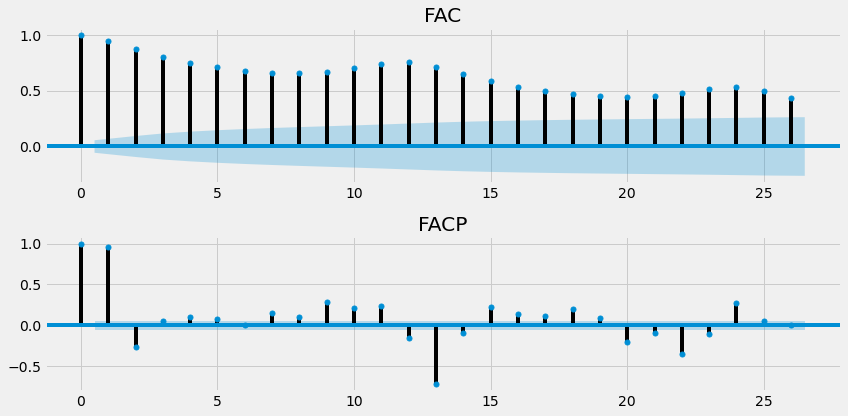

In [360]:
df_o = df.set_index('Mês').copy()
tsplot(df_o, '#Passageiros', title='Tráfego mensal de passageiros em voos internacionais', figsize=(12, 6), lags=26)
plt.savefig('../images/fac_facp.png', dpi=300)

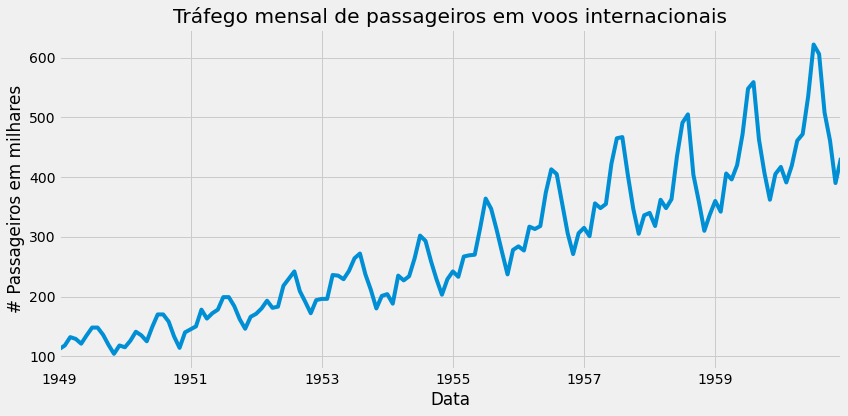

In [344]:
ax = df.plot(x='Mês', y='#Passageiros', figsize=(12, 6), title='Tráfego mensal de passageiros em voos internacionais', legend=False)
ax.set_ylabel('# Passageiros em milhares')
ax.set_xlabel('Data')
plt.tight_layout()

plt.savefig('../images/serie_airline.png', dpi=300)


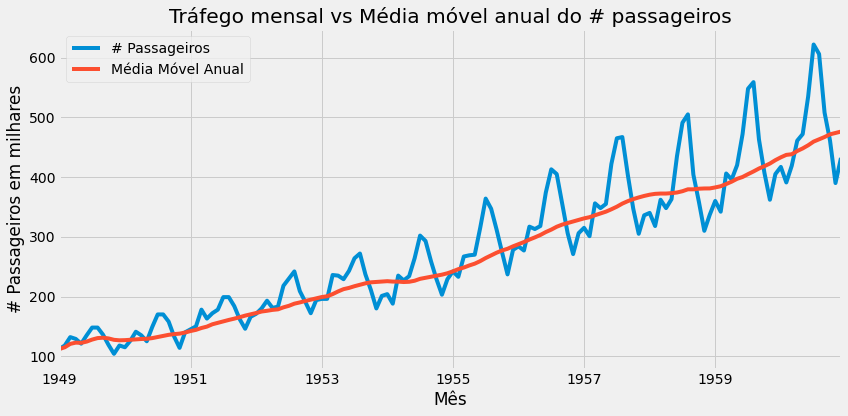

In [368]:
# Rolling window functions
rolling_air = df.copy()
rolling_air = rolling_air.set_index('Mês')
rolling_air = rolling_air['#Passageiros'].rolling('365D').mean()

ax = df.plot(x='Mês', y='#Passageiros', figsize=(12, 6), title='Tráfego mensal vs Média móvel anual do # passageiros', legend=False)
ax.set_ylabel('# Passageiros em milhares')
ax.set_xlabel('Data')

rolling_air.plot(figsize=(12, 6))

plt.legend(['# Passageiros', 'Média Móvel Anual'])
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.tight_layout()
plt.savefig('../images/serie_movel.png', dpi=300)
plt.show()

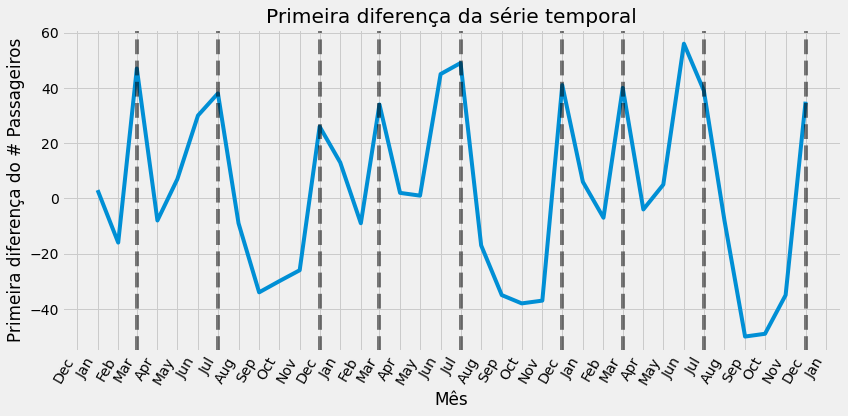

In [376]:
df_diff = df.copy()
df_diff = df_diff.set_index('Mês')
df_diff = df_diff.diff()
anos = ['1954', '1955', '1956']
df_diff = df_diff[min(anos): max(anos)]

ax = df_diff.plot(y='#Passageiros', figsize=(12, 6), title='Primeira diferença da série temporal', legend=False, x_compat=True)
_ = ax.set_ylabel('Primeira diferença do # Passageiros')

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
#ax.set_xticklabels(xlabels, Rotation=2)
# set monthly locator
ax.xaxis.set_major_locator(locator)
# set formatter
ax.xaxis.set_major_formatter(fmt)
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis='x', rotation=60)

for ano in anos:
    for mes in ['12', '3', '7']:
        ax.axvline(pd.Timestamp(f'{ano}-{mes}-01'), color='k', linestyle='--', alpha=0.5)
        
plt.tight_layout()
plt.savefig('../images/serie_1_diff.png', dpi=300)

* Parece que tem sazonalidade DEZ-JAN ---> CAI ----> JUL - SOBE, JUL

In [335]:
time_series = df['#Passageiros']

In [276]:
w_amostral = time_series.std()**2

In [258]:
w_amostral

119.96631694294321

In [231]:
from pydlm import modelTuner
myTuner = modelTuner(method='gradient_descent', loss='mse')

In [277]:
#percents = np.array([0.05, 0.1, 0.25, 0.5, 1])

In [323]:
time_series[80:85] = -1

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


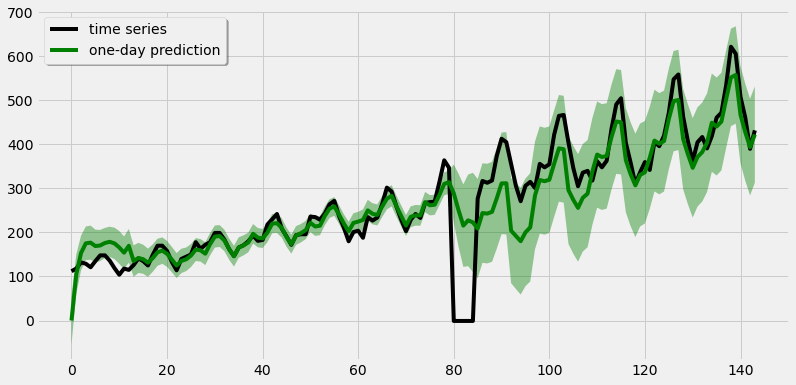

>>>>>>>>>>>>>>>>>>>>>>5 e MSE: 3735.531704897044


In [336]:
for w in [5]:    
    # A linear trend
    linear_trend = trend(degree=1, discount=0.98, name='Tendência Linear', w=w)
    # A seasonality
    yearly = seasonality(period=12, discount=0.98, name='Anual', w=w)

    # Build a simple dlm
    simple_dlm = dlm(time_series) + yearly + linear_trend

    simple_dlm.fit()

    # Plot each component (attribute the time series to each component)
    simple_dlm.turnOff('filtered plot')
    simple_dlm.turnOff('smoothed plot')
#     simple_dlm.plot('Anual')
#     simple_dlm.plot('Tendência Linear')

    simple_dlm.turnOn('predict plot')
    #simple_dlm.turnOn('filtered plot')
    #simple_dlm.turnOn('smoothed plot')

    simple_dlm.plot()
    print(f'>>>>>>>>>>>>>>>>>>>>>>{w} e MSE: {simple_dlm.getMSE()}')
    print('================================')

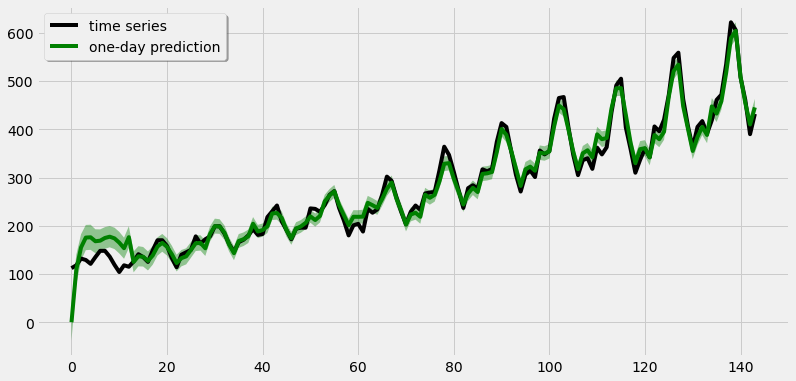

<Figure size 864x432 with 0 Axes>

In [320]:
simple_dlm.turnOn('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.turnOff('smoothed plot')

simple_dlm.plot()
plt.savefig('sss.png')

In [ ]:
simple_dlm.fit()

# Plot each component (attribute the time series to each component)
simple_dlm.turnOff('filtered plot')
simple_dlm.turnOff('smoothed plot')
simple_dlm.plot('Anual')
simple_dlm.plot('Tendência Linear')

#simple_dlm.turnOn('predict plot')
#simple_dlm.turnOn('filtered plot')
#simple_dlm.turnOn('smoothed plot')

simple_dlm.plot()
print(f'>>>>>>>>>>>>>>>>>>>>>>{w} e MSE: {simple_dlm.getMSE()}')
print('================================')

In [225]:
(len(df['Mês'].dt.year.unique())-1)*12

132

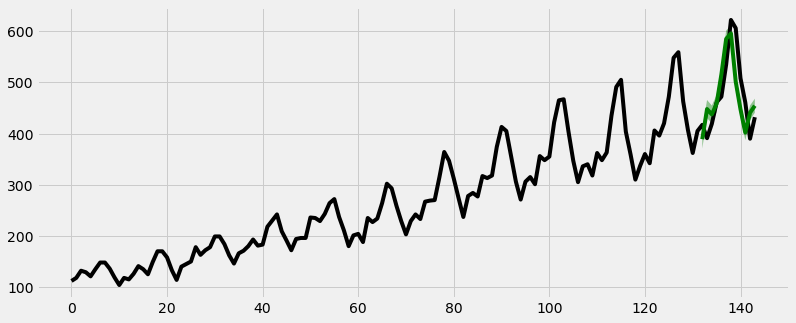

In [226]:
simple_dlm.plotPredictN(N=12, date=132)

In [229]:
simple_dlm.predictN(N=12, date=132)

([388.9964749376245,
  447.87233128727024,
  437.41503166550706,
  458.41111054491387,
  515.4829849176231,
  585.062191384676,
  595.7000887253505,
  501.33177021032674,
  447.4459949883535,
  401.8832460761897,
  440.7761907853717,
  454.3948027812229],
 [85.36165169902179,
  81.78312912698806,
  78.17614817969687,
  74.60766342183828,
  71.11193751769275,
  67.70344635639162,
  64.38548224473766,
  61.15610504977746,
  58.01223830877934,
  54.95244277941586,
  51.97879916192626,
  49.09837856880219])

In [ ]:
simple_dlm.plot('Tendencia Linear')
simple_dlm.plot('Anual')
#simple_dlm.plot('Trimestral')

In [ ]:
simple_dlm.getMSE()

In [ ]:
features = df_monthly[df_monthly.columns.difference(['price'])].values

In [ ]:
from pydlm import dynamic
regressor10 = dynamic(features=features, discount=1, name='regressor10', w=10)

drm = dlm(time_series) + linear_trend + yearly + regressor10
drm.fit()
drm.getMSE()

# Plot the fitted results
drm.turnOff('data points')
drm.plot()

In [ ]:
# Plot each component (attribute the time series to each component)
drm.turnOn('predict plot')
drm.turnOff('filtered plot')
drm.turnOff('smoothed plot')

#drm.plot('linear_trend')
drm.plot()


In [ ]:
drm.plotPredictN(date=100, N=49)